# Analyze discounts

Project information:

"Before starting the analysis, let’s establish a couple of things:

- Analyzing discounts means looking at which products have been sold. Remember that this information is stored in the `orderlines` table.
- Discounts are defined as the difference between `orderlines.unit_price` and `products.price`. Merging both tables and creating a column that contains the discount is, thus, probably a good idea. Drop the columns that you don’t need so that they don’t confuse you.

When exploring discounts, make sure to always have the **time** dimension in consideration: Eniac does not always offer its products at the same price. A critical question, hence, is whether revenue grows whenever discounts increase."

In [243]:
import pandas as pd
import matplotlib.pyplot as plt

Load cleaned DataFrames

In [244]:
# orderlines_qu.csv
path = "C:/Users/ruben/local_repos/WBS/Data_Science/Section_3/Data_Cleaning_Storytelling_with_Pandas_and_Matplotlib/data/quality_data/orderlines_qu.csv"
orderlines_qu = pd.read_csv(path)

# products_cl.csv
path = "C:/Users/ruben/local_repos/WBS/Data_Science/Section_3/Data_Cleaning_Storytelling_with_Pandas_and_Matplotlib/data/clean_data/products_cl.csv"
products_cl = pd.read_csv(path)

Verify the columns for merging.

In [245]:
orderlines_qu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60179 entries, 0 to 60178
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                60179 non-null  int64  
 1   id_order          60179 non-null  int64  
 2   product_id        60179 non-null  int64  
 3   product_quantity  60179 non-null  int64  
 4   sku               60179 non-null  object 
 5   unit_price        60179 non-null  float64
 6   date              60179 non-null  object 
dtypes: float64(1), int64(4), object(2)
memory usage: 3.2+ MB


In [246]:
products_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19280 entries, 0 to 19279
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   sku                     19280 non-null  object 
 1   name                    19280 non-null  object 
 2   desc                    19273 non-null  object 
 3   price                   19280 non-null  float64
 4   promo_price             19280 non-null  float64
 5   in_stock                19280 non-null  int64  
 6   type                    19230 non-null  object 
 7   is_promo_price_greater  19280 non-null  bool   
 8   promo_greater_with      19280 non-null  float64
dtypes: bool(1), float64(3), int64(1), object(4)
memory usage: 1.2+ MB


I decide to go with 'sku' column.

sku – stock keeping unit: a unique identifier for each product

In [247]:
merged_df = pd.merge(orderlines_qu, products_cl, on='sku')

In [248]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69362 entries, 0 to 69361
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      69362 non-null  int64  
 1   id_order                69362 non-null  int64  
 2   product_id              69362 non-null  int64  
 3   product_quantity        69362 non-null  int64  
 4   sku                     69362 non-null  object 
 5   unit_price              69362 non-null  float64
 6   date                    69362 non-null  object 
 7   name                    69362 non-null  object 
 8   desc                    69358 non-null  object 
 9   price                   69362 non-null  float64
 10  promo_price             69362 non-null  float64
 11  in_stock                69362 non-null  int64  
 12  type                    69351 non-null  object 
 13  is_promo_price_greater  69362 non-null  bool   
 14  promo_greater_with      69362 non-null

Modify the 'date' type.

In [249]:
merged_df['date'] = pd.to_datetime(merged_df['date'])

Drop the columns that I don’t need so that they don’t confuse me.

In [250]:
merged_df = merged_df[['id_order', 'name', 'sku', 'price', 'unit_price', 'product_quantity', 'date']]

In [251]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69362 entries, 0 to 69361
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id_order          69362 non-null  int64         
 1   name              69362 non-null  object        
 2   sku               69362 non-null  object        
 3   price             69362 non-null  float64       
 4   unit_price        69362 non-null  float64       
 5   product_quantity  69362 non-null  int64         
 6   date              69362 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 4.2+ MB


Based on the project information, the discount amount is calculated by the difference between 'price' and 'unit_price'.

I decide to create a column with the discount amount.

In [252]:
merged_df['discount_amount'] = merged_df['price'] - merged_df['unit_price']

Remove the rows with negative value in discount_amount

In [253]:
merged_df = merged_df[merged_df['discount_amount'] >= 0]

On every row in the dataframe we have:
- a column with the `name` of that product sold in a specific order;
- a column with the `price` of that product sold in a specific order;
- a column with the `quantity` of that product sold in a specific order;

But...

We don't have:
- a column with the `total` (`price` * `product_quantity`) revenue for a specific row (a specific product sold in a specific order).

Because of that, I will create what we miss and we need.

In [254]:
merged_df['total_price_by_prod_qty'] = merged_df['price'] * merged_df['product_quantity']

The same thing, but for `unit_price` which is the discounted  `price` of a product.

In [255]:
merged_df['total_unit_price_by_prod_qty'] = merged_df['unit_price'] * merged_df['product_quantity']

Create the `discount_amount_by_prod_qty` which will be the amount of discount for one row in the dataframe.

In [256]:
merged_df['discount_amount_by_prod_qty'] = merged_df['total_price_by_prod_qty'] - merged_df['total_unit_price_by_prod_qty']

Calculate the discount percentage over the original price

In [257]:
merged_df['discount_rate'] = merged_df['discount_amount_by_prod_qty'] / merged_df['total_price_by_prod_qty'] * 100


In [260]:
merged_df['discount_rate'].describe()

count    67667.000000
mean        21.369954
std         18.931390
min          0.000000
25%          8.197398
50%         16.668056
75%         27.002700
max         99.979996
Name: discount_rate, dtype: float64

##### When exploring discounts, make sure to always have the time dimension in consideration: Eniac does not always offer its products at the same price. 

##### A critical question, hence, is whether revenue grows whenever discounts increase.

##### Weekly revenue and discount average.

In [261]:
# Setting max rows to None for complete DataFrame display.
pd.set_option('display.max_rows', None)

In [276]:
# Grouping by year and week of the date column, then calculating mean 
# of 'discount_rate'and sum of 'total_unit_price_by_prod_qty'
(
    merged_df
    .groupby(
              [merged_df['date'].dt.year, 
              merged_df['date'].dt.week])
    .agg({'discount_rate': ['mean'], 'total_unit_price_by_prod_qty': ['sum']})
)


discount_rate total_unit_price_by_prod_qty
                   mean                          sum
date date                                           
2017 1        20.834322                   1808873.66
     2        25.080934                   2000919.63
     3        21.718123                   1670037.96
     4        26.080299                   1821856.20
     5        21.181296                   1555705.11
     6        17.240450                   1423977.14
     7        21.818013                    932443.92
     8        18.448992                    766336.37
     9        19.128797                    302782.25
     10       15.027907                    252500.33
     11       15.263085                    342601.50
     12       19.307766                    306047.19
     13       13.135818                   1034702.26
     14       14.895103                    959210.81
     15       18.107156                    686615.15
     16       19.387064                    744448.07
     17       16.710219                    192127.96
     18       15.506607                    672026.54
     19       16.736328                    516922.15
     20       14.674084                    594162.54
     21       15.946477                    241535.92
     22       17.075714                    668142.31
     23       19.123073                    730392.67
     24       19.678521                    309980.07
     25       15.796479                    226123.91
     26       20.124500                    259842.73
     27       30.040779                    448324.64
     28       21.875899                    584348.74
     29       23.204611                    254470.92
     30       23.434511                    279356.59
     31       24.408612                    182868.15
     32       22.387486                    222346.24
     33       21.903625                    140653.54
     34       20.820122                    196191.40
     35       21.574057                    255048.33
     36       18.920204                    256674.32
     37       20.736363                    146556.67
     38       20.807156                    423720.06
     39       20.482017                    370964.44
     40       20.186901                    281143.60
     41       20.757125                    240875.20
     42       26.790025                    366393.98
     43       20.038606                    384146.78
     44       20.233474                    318674.02
     45       19.333134                    383885.15
     46       17.342029                    245180.89
     47       22.768366                   2411972.71
     48       21.869152                    850505.99
     49       17.000465                    279377.53
     50       16.626365                    520799.12
     51       22.960004                    675822.15
     52       21.944178                   1306320.80
2018 1        21.289884                    820882.26
     2        25.142425                    672554.34
     3        23.348373                    565540.12
     4        22.865076                    403676.01
     5        21.180856                    615399.26
     6        19.524928                    329653.60
     7        28.904032                    315753.94
     8        19.224636                    309759.76
     9        20.522704                    385628.63
     10       20.624279                    354230.96
     11       24.145913                     91405.62

This script below will group the data by `year` and `week`, and then it will calculate the `mean` of the `'discount_rate'` column and `sum` of the `'total_unit_price_by_prod_qty'` column. 

Then it will plot the 'Discount Average Rate' and 'Revenue' columns on the same figure but with different y-axes, so you can see both data sets on the same plot with different scales.

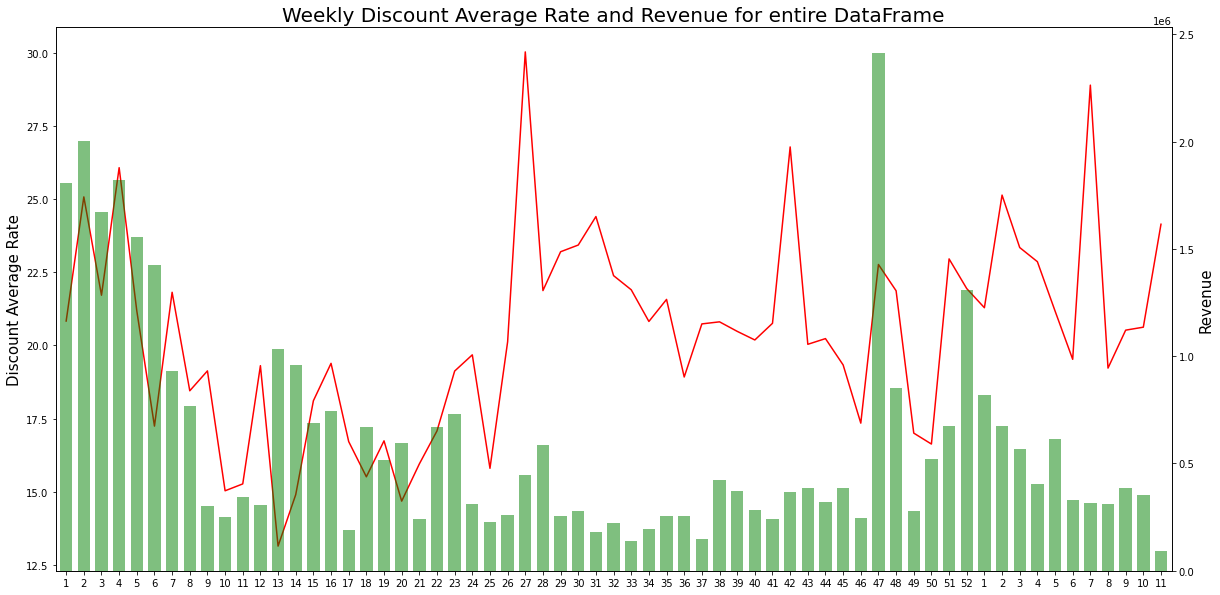

In [274]:
# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(20,10))

# Groupby date and aggregate the mean of 'discount_rate' 
# Rename the column to 'Discount Rate'
df1 = (
    merged_df
    .groupby([merged_df['date'].dt.year, merged_df['date'].dt.week])
    .agg({'discount_rate': ['mean']})
)

# Plot the 'Discount Rate' column in the first axis
df1.plot(ax=ax, color='r')
ax.set_ylabel('Discount Average Rate', fontsize=15)

# Create a second y-axis
ax2 = ax.twinx()

# Groupby date and aggregate the sum of 'total_unit_price_by_prod_qty'
# Rename the column to 'Revenue'
df2 = (
    merged_df
    .groupby([merged_df['date'].dt.year, merged_df['date'].dt.week])
    .agg({'total_unit_price_by_prod_qty': ['sum']})
)

# Plot the 'Revenue' column in the second axis
df2.plot(kind='bar', ax=ax2, color='g',alpha=0.5, width=0.7)
ax2.set_ylabel('Revenue', fontsize=15)
ax2.set_xticklabels([f'{week}' for _, week in df2.index])

# Set the title and labels
ax.legend().set_visible(False)
ax2.legend().set_visible(False)
ax.xaxis.label.set_visible(False)
plt.title('Weekly Discount Average Rate and Revenue for entire DataFrame', fontsize=20)
plt.show()
